# Pipeline for High-z Radio Galaxies 09: Redshift prediction

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC).  

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

***

## Reading data

In [13]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [14]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [15]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [16]:
mqc_version = '7_4d'  # '7_2'

In [17]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [18]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [19]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [20]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
full_catalog_df = full_catalog_df.loc[full_catalog_df.loc[:, 'is_AGN'] == 1]

In [23]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and {n_is_gal:,} are identified as galaxies.')

In this dataset, with 30,395 elements,
30,395 of them are marked as AGN, and 0 are identified as galaxies.


---

## Possible correlations

In [24]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [25]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [26]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [27]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [28]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [29]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [30]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [31]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (30395, 41)
Data for Modeling (Train and Test): (24316, 41)
Unseen Data For Validation: (6079, 41)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [32]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [33]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [34]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [35]:
rsd_vals

z_y             465.637101
i_z             302.041774
r_i             168.344746
radio_detect    143.952309
g_r             142.708985
g_i             110.908316
w1_w2           102.839602
w2_w3            33.856660
band_num         21.841029
J_H              21.573879
H_K              20.009646
w3_w4            16.602840
ymag              5.962701
W1mproPM          5.811013
rmag              5.757531
zmag              5.742339
gmag              5.728517
imag              5.716521
W2mproPM          5.669805
W1mag             5.287419
i/K               5.268097
g/J               5.234658
W2mag             5.224200
w1/w4             5.173709
r/H               5.151608
w2/w4             5.030257
w1/w3             4.138731
y/W2              3.605342
z/W1              3.518516
W3mag             3.024125
i/y               2.539949
r/z               2.215549
NUVmag            2.194402
Hmag              1.868874
Jmag              1.821054
W4mag             1.786737
FUV/K             1.519753
K

In [36]:
correlation = norm_train_test_df.corr()

In [37]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [38]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [39]:
target_feat = 'radio_detect'

In [40]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [41]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [42]:
list_drop_corr

['Jmag',
 'i/K',
 'W2mag',
 'W2mproPM',
 'W1mag',
 'w2/w4',
 'Kmag',
 'w1/w4',
 'imag',
 'r/H',
 'g/J',
 'FUV_NUV',
 'gmag',
 'J/K',
 'zmag',
 'w1/w3',
 'W3mag',
 'rmag',
 'Hmag',
 'W1mproPM',
 'g_i']

In [43]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [44]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [45]:
corr_discard = norm_train_test_discard.corr()

In [46]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
ymag      w2_w3       0.736970
z_y       i/y         0.732143
ymag      band_num    0.678584
r/z       i_z         0.663001
w3_w4     ymag        0.641163
NUVmag    FUVmag      0.629334
y/W2      z/W1        0.628881
w2_w3     band_num    0.621424
r_i       r/z         0.601351
H_K       FUV/K       0.546561
ymag      H_K         0.520172
w3_w4     NUVmag      0.517503
          w2_w3       0.499516
H_K       w3_w4       0.478999
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

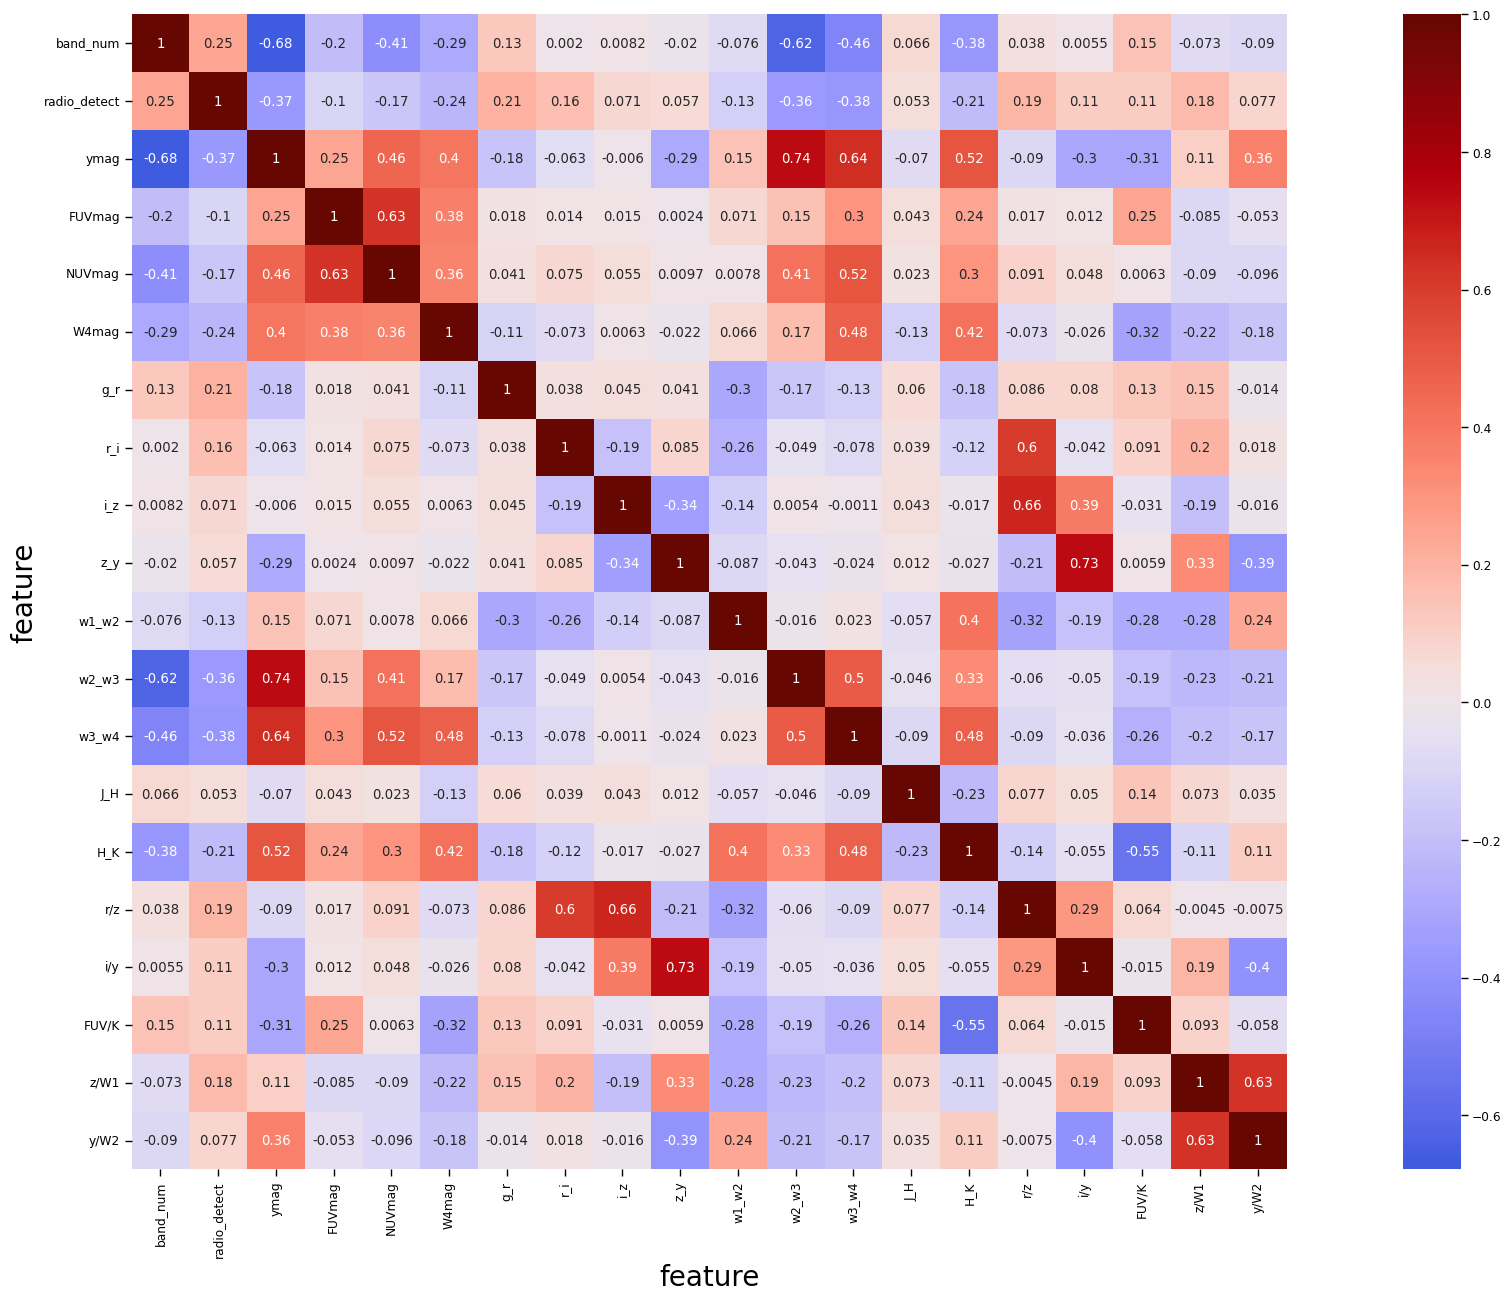

In [47]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [48]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [49]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [50]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
FUV/K     FUV/K           1.000000
band_num  ymag            0.491465
J_H       H_K             0.390293
NUVmag    FUVmag          0.352525
ymag      H_K             0.306450
w3_w4     radio_detect    0.305377
band_num  w2_w3           0.293498
FUV/K     H_K             0.276397
z_y       i/y             0.228403
ymag      radio_detect    0.223788
band_num  radio_detect    0.207456
ymag      w2_w3           0.196685
z_y       ymag            0.195337
band_num  H_K             0.186203
W4mag     radio_detect    0.178495
band_num  z_y             0.178244
w3_w4     w2_w3           0.172979
w2_w3     radio_detect    0.162261
i/y       z_y             0.151388
w2_w3     ymag            0.150613
dtype: float64

In [51]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [52]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [53]:
target_feat = 'radio_detect'

In [54]:
list_drop_pps = []

In [55]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [56]:
list_drop_pps

[]

In [57]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [58]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [59]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w3_w4,radio_detect,0.305377,classification,True,weighted F1,0.5564,0.691865,DecisionTreeClassifier()
1,ymag,radio_detect,0.223788,classification,True,weighted F1,0.5564,0.655672,DecisionTreeClassifier()
2,band_num,radio_detect,0.207456,classification,True,weighted F1,0.5564,0.648428,DecisionTreeClassifier()
3,W4mag,radio_detect,0.178495,classification,True,weighted F1,0.5564,0.635580,DecisionTreeClassifier()
4,w2_w3,radio_detect,0.162261,classification,True,weighted F1,0.5564,0.628379,DecisionTreeClassifier()
5,w1_w2,radio_detect,0.144597,classification,True,weighted F1,0.5564,0.620543,DecisionTreeClassifier()
6,J_H,radio_detect,0.127944,classification,True,weighted F1,0.5564,0.613156,DecisionTreeClassifier()
7,H_K,radio_detect,0.123038,classification,True,weighted F1,0.5564,0.610979,DecisionTreeClassifier()
8,FUV/K,radio_detect,0.109316,classification,True,weighted F1,0.5564,0.604893,DecisionTreeClassifier()
9,r/z,radio_detect,0.101272,classification,True,weighted F1,0.5564,0.601324,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [60]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('FUVmag')  # After Boruta

In [61]:
feats_2_discard = list_drop_corr + list_drop_pps + ['FUVmag']

Boruta discards one feature.

In [62]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu='force')  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24316, 41)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [63]:
pyc.get_config('X').columns

Index(['band_num', 'ymag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1',
       'y/W2'],
      dtype='object')

In [64]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,cuml.linear_model.logistic_regression.Logistic...,True
knn,K Neighbors Classifier,cuml.neighbors.kneighbors_classifier.KNeighbor...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,cuml.linear_model.mbsgd_classifier.MBSGDClassi...,True
rbfsvm,SVM - Radial Kernel,pycaret.internal.cuml_wrappers.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,cuml.linear_model.ridge.Ridge,True


In [65]:
models_clf_gpu       = ['catboost', 'xgboost', 'lightgbm', 'dummy', 'lr', 'knn', 'ridge', 'rf']  # knn too slow, ridge does not work
final_selection_clf  = ['lightgbm', 'catboost', 'rf', 'lr', 'ridge', 'dummy']
n_models             = 5
# top_model_radio      = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
top_model_radio      = pyc.compare_models(n_select=n_models, include=models_clf_gpu, sort='MCC')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7670,0.7975,0.4939,0.7016,0.5795,0.4251,0.4377,0.4000
catboost,CatBoost Classifier,0.7674,0.8013,0.4821,0.7099,0.5742,0.4222,0.4371,17.5810
rf,Random Forest Classifier,0.7662,0.7960,0.4903,0.7014,0.5769,0.4224,0.4354,0.4950
lr,Logistic Regression,0.7614,0.7885,0.4523,0.7089,0.5520,0.4002,0.4190,0.1020
ridge,Ridge Classifier,0.7615,0.0000,0.4471,0.7134,0.5494,0.3987,0.4190,0.0520
xgboost,Extreme Gradient Boosting,0.7572,0.7811,0.4987,0.6708,0.5720,0.4077,0.4165,0.3600
knn,K Neighbors Classifier,0.7450,0.7408,0.4899,0.6427,0.5556,0.3814,0.3885,0.0190
dummy,Dummy Classifier,0.6745,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [66]:
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7733,0.8148,0.5072,0.7132,0.5928,0.4419,0.4542
1,0.7756,0.8054,0.5217,0.7118,0.6021,0.4509,0.4615
2,0.7685,0.8022,0.4928,0.7073,0.5809,0.4279,0.4412
3,0.7703,0.7983,0.5126,0.7012,0.5923,0.4377,0.4481
4,0.7474,0.7696,0.4422,0.6694,0.5326,0.3693,0.3842
5,0.7638,0.7863,0.5036,0.6872,0.5812,0.4222,0.4320
6,0.7985,0.8203,0.5560,0.7605,0.6423,0.5067,0.5188
7,0.7703,0.8088,0.5162,0.6993,0.5940,0.4388,0.4486
8,0.7562,0.8028,0.4657,0.6844,0.5542,0.3947,0.4085


In [67]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='MCC',\
                               search_library='tune-sklearn', search_algorithm='random')  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7645,0.8079,0.5090,0.6861,0.5845,0.4252,0.4344
1,0.7703,0.7966,0.5325,0.6909,0.6014,0.4438,0.4513
2,0.7667,0.7994,0.5036,0.6958,0.5843,0.4279,0.4387
3,0.7685,0.7929,0.5144,0.6951,0.5913,0.4348,0.4444
4,0.7444,0.7663,0.4639,0.6506,0.5416,0.3713,0.3815
5,0.7609,0.7875,0.5072,0.6771,0.5800,0.4176,0.4261
6,0.7873,0.8210,0.5433,0.7341,0.6245,0.4807,0.4913
7,0.7597,0.8047,0.4874,0.6835,0.5690,0.4088,0.4201
8,0.7667,0.8012,0.5000,0.6977,0.5825,0.4268,0.4382


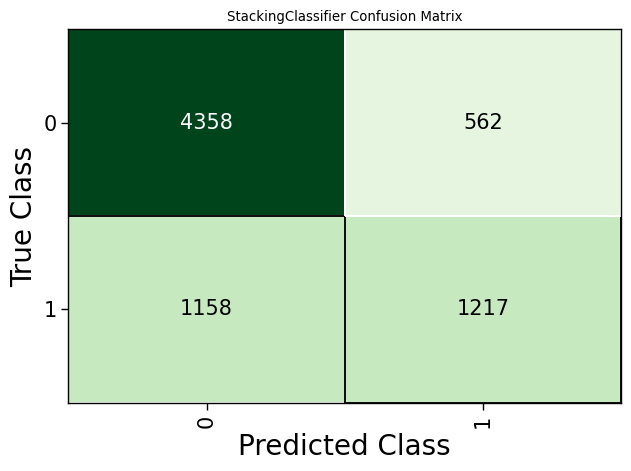

In [68]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

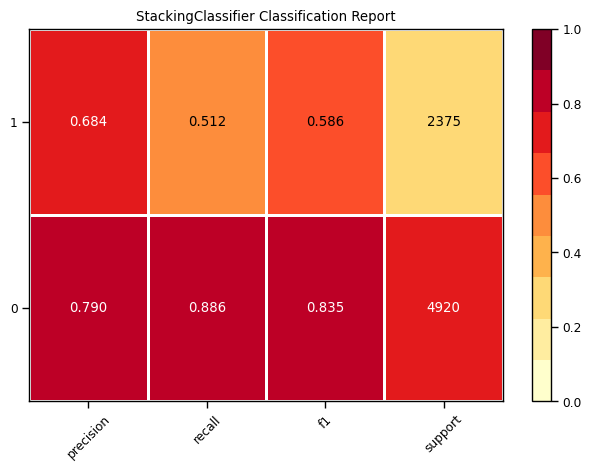

In [69]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

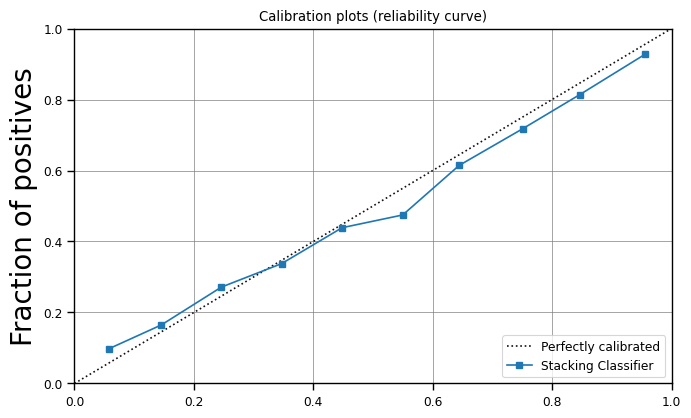

In [70]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

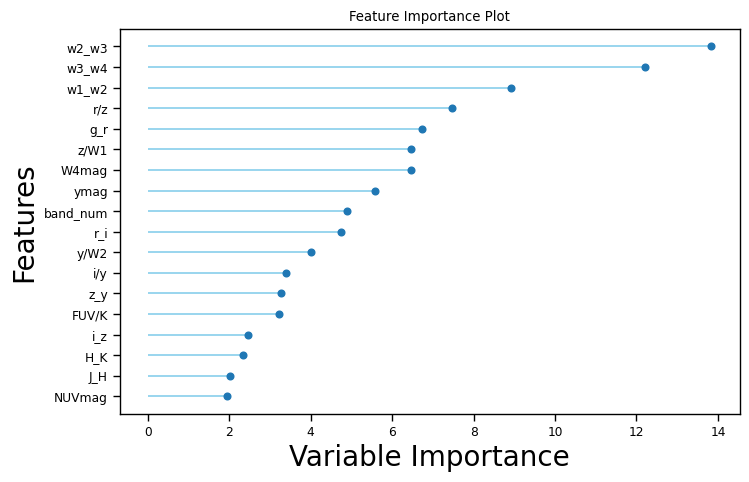

In [71]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [72]:
pyc.plot_model(tuned_radio_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('catboost', <catboost.core.CatBoostClassifie..."
final_estimator,"LGBMClassifier(bagging_fraction=0.8, bagging_f..."
n_jobs,1
passthrough,True
stack_method,auto
verbose,0


In [73]:
plt.rcParams.update(plt.rcParamsDefault)

In [74]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7642,0.7946,0.5124,0.6841,0.5859,0.4258,0.4345


,band_num,ymag,NUVmag,W4mag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,radio_detect,Label,Score_0,Score_1
0,-0.012262,-0.135535,0.405590,0.25807,-0.750148,1.417719,0.791471,0.877970,-1.475092,1.022007,...,0.179137,1.614049,1.342720,-0.033564,0.039040,-1.291853,0,0,0.8887,0.1113
1,0.969687,-0.596731,-2.509975,0.25807,0.324467,-0.546453,-0.058835,0.364228,0.495493,-0.944185,...,0.179137,-0.429448,0.369183,-0.033564,0.015593,-0.062924,0,0,0.6161,0.3839
2,-0.012262,0.187757,0.405590,0.25807,-0.369083,0.410415,0.425785,0.622150,1.079324,0.605736,...,0.179137,0.594264,0.878803,-0.033564,-0.436024,-0.494592,0,0,0.7752,0.2248
3,-0.012262,-0.180996,0.405590,0.25807,-0.610023,-1.109676,-0.039757,0.535907,-0.470464,-0.800328,...,0.179137,-0.807582,0.527118,-0.033564,1.011569,0.479570,0,0,0.7228,0.2772
4,-0.433206,-0.253291,0.405590,0.25807,3.587730,2.148983,0.465203,0.186554,-1.863500,-0.716713,...,0.179137,2.024647,0.531278,-0.033564,1.341725,0.242064,1,1,0.1276,0.8724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7290,-0.012262,-0.603103,0.405590,0.25807,-0.210045,-0.439630,-0.762343,0.326741,0.424097,-0.105787,...,0.179137,-0.989290,-0.198227,-0.033564,-1.199519,-1.098034,0,0,0.6901,0.3099
7291,-0.012262,-0.158408,0.405590,0.25807,-0.423088,0.038287,-0.062429,0.049463,0.094615,0.783074,...,0.179137,-0.019244,0.037868,-0.033564,-1.350613,-1.141191,0,0,0.8953,0.1047
7292,-0.433206,-0.220886,0.405590,0.25807,3.243944,1.138768,0.390150,1.254788,-2.160213,1.317145,...,0.179137,1.114388,1.453391,-0.033564,0.425046,-1.637363,0,0,0.5007,0.4993
7293,0.457854,-0.627142,0.269266,0.25807,-0.117013,-0.666454,0.447481,-0.139991,-0.747402,-0.954790,...,0.179137,-0.077518,0.227601,-0.033564,0.136574,-0.106441,1,0,0.7756,0.2244


In [75]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7642,0.7946,0.5124,0.6841,0.5859,0.4258,0.4345


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [76]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will b

In [77]:
if save_model_flag:
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_04_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('../../models/config_classification_radio_detect_apr_27_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_radio_clf = pyc.load_model('models/classification_radio_detect_may_04_2022')

### Prediction process

#### Feature importances

In [90]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, 'catboost')
extended_cols_radio = extended_cols_radio.insert(0, 'rf')
extended_cols_radio = extended_cols_radio.insert(0, 'lr')
extended_cols_radio = extended_cols_radio.insert(0, 'ridge')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [91]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [92]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [93]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [94]:
base_models_names = [model[0] for model in estimators_list]

In [95]:
coef_sorted_base_df = {}

In [96]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [97]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [98]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for lr...
Calculating for ridge...


catboost                   lr                ridge           
     Feature Importance   Feature Importance   Feature Importance
0      w2_w3  15.661780       z_y  16.959581     w3_w4  15.570731
1      w3_w4  12.237555     w3_w4  12.726399       z_y  14.731361
2      W4mag   8.553849       i/y  11.543405       i/y  10.695950
3        r/z   7.945153      y/W2  10.890247      ymag   9.660396
4      w1_w2   7.668793      ymag   7.670782      y/W2   9.563860
5       ymag   6.448165       i_z   7.301648       i_z   6.484438
6        g_r   6.155879      z/W1   6.033734       r/z   6.224242
7       z/W1   6.059088       r/z   5.489623     w1_w2   4.918073
8   band_num   4.779569     w1_w2   5.118663     w2_w3   4.844584
9       y/W2   4.087300     W4mag   4.105383       g_r   4.468768
10       r_i   3.619124     w2_w3   4.072843     W4mag   4.467861
11       i/y   3.160131       g_r   3.558715      z/W1   3.603326
12    NUVmag   2.902695    NUVmag   1.350611  band_num   1.958792
13       i_z   2.432133  band_num   1.190919    NUVmag   1.487252
14       z_y   2.347061       H_K   0.717829       r_i   0.676986
15       H_K   2.160166     FUV/K   0.596620       H_K   0.316964
16     FUV/K   1.977147       r_i   0.495157     FUV/K   0.299907
17       J_H   1.804411       J_H   0.177853       J_H   0.026507

In [99]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,lr,7.584541
1,g_r,7.543133
2,w1_w2,7.418910
3,r_i,7.156660
4,ridge,6.721877
5,z/W1,6.694272
6,i/y,6.390614
7,i_z,6.349206
8,z_y,6.273292
9,r/z,6.252588


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w2_w3	15.662
w3_w4	12.238
W4mag	8.554
r/z	7.945
w1_w2	7.669
ymag	6.448
g_r	6.156
z/W1	6.059
band_num	4.780
y/W2	4.087
r_i	3.619
i/y	3.160
NUVmag	2.903
i_z	2.432
z_y	2.347
H_K	2.160
FUV/K	1.977
J_H	1.804


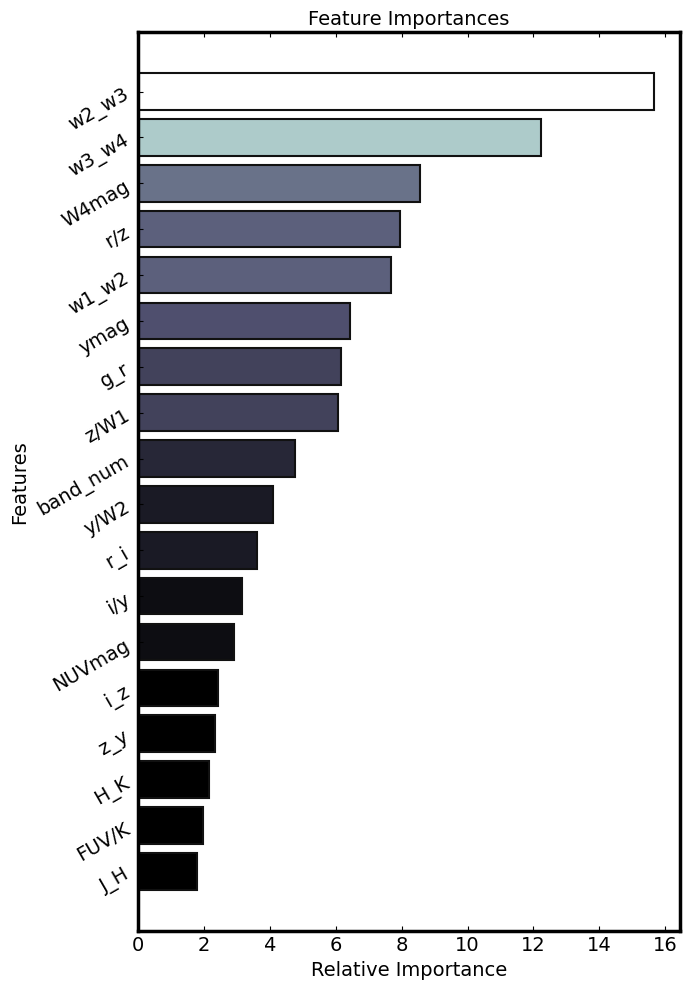

In [100]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_02.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [101]:
radio_pred_threshold = 0.5
# radio_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [102]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7715,0.8059,0.5154,0.7034,0.5949,0.4410,0.4514


Create confusion matrix with validation data.

In [103]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

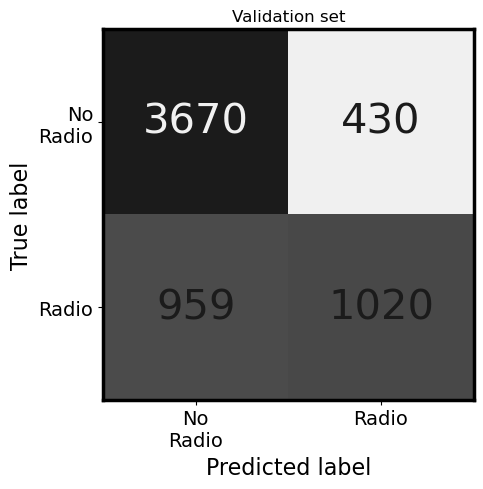

In [104]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

In [105]:
# TN_radio, FP_radio, FN_radio, TP_radio = cm_mat_val.flatten().astype('float32')

In [106]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [107]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.4514
Accuracy is                         ACC = 0.7715
F1-score is                          F1 = 0.5949
Recall is                           TPR = 0.5154


---

### Separate AGN and galaxies for Confusion Matrices

In [110]:
# validation_prediction_clf_AGN = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 1]
# validation_prediction_clf_gal = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 0]

In [ ]:
# cm_mat_val_gal = np.array([[np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 1))]])
# 
# cm_mat_val_AGN = np.array([[np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 1))]])

In [ ]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
# plot_conf_mat(cm_mat_val_gal, title='Validation set - Galaxies', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_gal_02.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
# plot_conf_mat(cm_mat_val_AGN, title='Validation set - AGN', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_AGN_02.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
# TN_radio_gal, FP_radio_gal, FN_radio_gal, TP_radio_gal = cm_mat_val_gal.flatten().astype('float32')
# TN_radio_AGN, FP_radio_AGN, FN_radio_AGN, TP_radio_AGN = cm_mat_val_AGN.flatten().astype('float32')

In [ ]:
# MCC_radio_val_gal    = MCC_from_CM(cm_mat_val_gal)
# ACC_radio_val_gal    = ACC_from_CM(cm_mat_val_gal)
# F1_radio_val_gal     = F1_from_CM(cm_mat_val_gal)
# Recall_radio_val_gal = Recall_from_CM(cm_mat_val_gal)

In [ ]:
# MCC_radio_val_AGN    = MCC_from_CM(cm_mat_val_AGN)
# ACC_radio_val_AGN    = ACC_from_CM(cm_mat_val_AGN)
# F1_radio_val_AGN     = F1_from_CM(cm_mat_val_AGN)
# Recall_radio_val_AGN = Recall_from_CM(cm_mat_val_AGN)

In [ ]:
# print('Metrics for galaxies in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_gal:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_gal:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_gal:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_gal:.4f}')

In [ ]:
# print('Metrics for AGN in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_AGN:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_AGN:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_AGN:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_AGN:.4f}')

---

In [112]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [113]:
train_prediction_clf = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8220,0.8801,0.5752,0.8255,0.6780,0.5604,0.5779


In [114]:
test_prediction_clf = pyc.predict_model(final_radio_clf, data=test_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8240,0.8788,0.5774,0.8292,0.6808,0.5646,0.5822


In [115]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [116]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

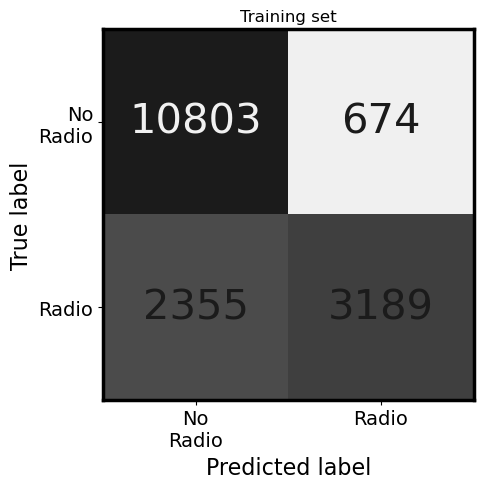

In [117]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

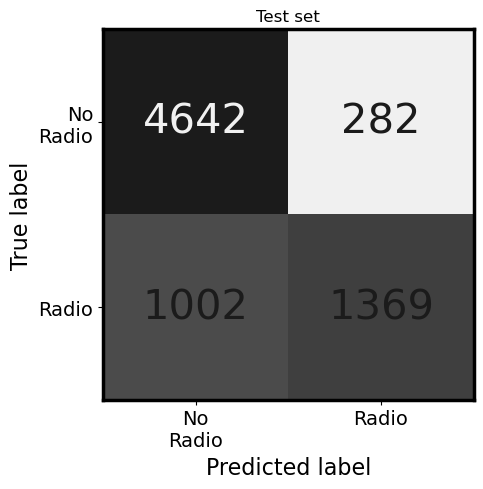

In [118]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

In [119]:
# TN_radio_train, FP_radio_train, FN_radio_train, TP_radio_train = cm_mat_train.flatten().astype('float32')

In [120]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [121]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.5779
Accuracy is                         ACC = 0.8220
F1-score is                          F1 = 0.6780
Recall is                           TPR = 0.5752


In [122]:
# TN_radio_test, FP_radio_test, FN_radio_test, TP_radio_test = cm_mat_test.flatten().astype('float32')

In [123]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [124]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.5822
Accuracy is                         ACC = 0.8240
F1-score is                          F1 = 0.6808
Recall is                           TPR = 0.5774


Calculate ROC AUC values and plots.

In [125]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [126]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.88013
Area under the curve (ROC) for test       = 0.87879
Area under the curve (ROC) for validation = 0.80590


In [127]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

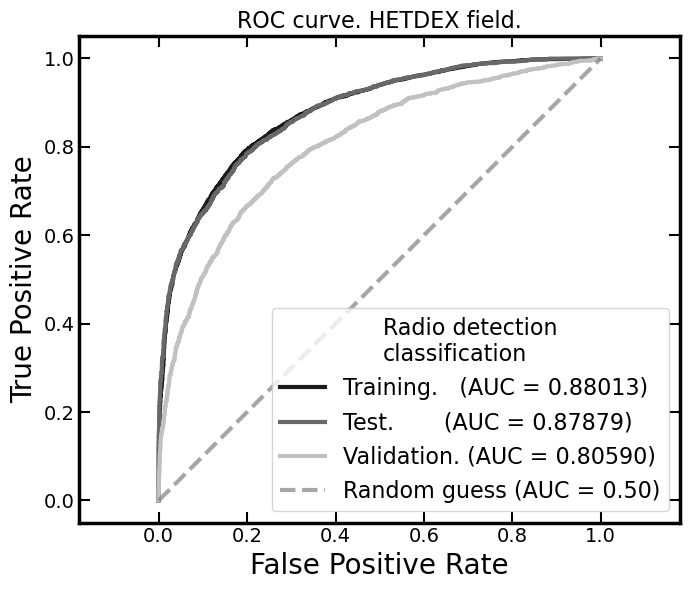

In [128]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()